In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler

In [ ]:
df_2017 = pd.read_excel('/content/native_Load_2017.xlsx').columns
df_2017

Index(['Hour Ending', 'COAST', 'EAST', 'FWEST', 'NORTH', 'NCENT', 'SOUTH',
       'SCENT', 'WEST', 'ERCOT'],
      dtype='object')

In [ ]:

df_2017 = pd.read_excel('/content/native_Load_2017.xlsx')
df_2018 = pd.read_excel('/content/Native_Load_2018.xlsx')
df_2019 = pd.read_excel('/content/Native_Load_2019.xlsx')

df_2017 = df_2017.rename(columns={'Hour Ending':'HourEnding'})

df = pd.concat([df_2017,df_2018,df_2019])
df['HourEnding'] =df['HourEnding'].str.strip()
df[['date','time','n_c']] = df['HourEnding'].str.split(expand=True)
df['datetime'] = (pd.to_datetime(df.pop('date'), format='%m/%d/%Y') + 
                  pd.to_timedelta(df.pop('time') + ':00'))

df = df[['datetime','ERCOT']]
df.set_index('datetime', inplace = True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26280 entries, 2017-01-01 01:00:00 to 2020-01-01 00:00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ERCOT   26280 non-null  float64
dtypes: float64(1)
memory usage: 410.6 KB


In [ ]:
df= df.resample('W').apply(sum)
df = df.reset_index()

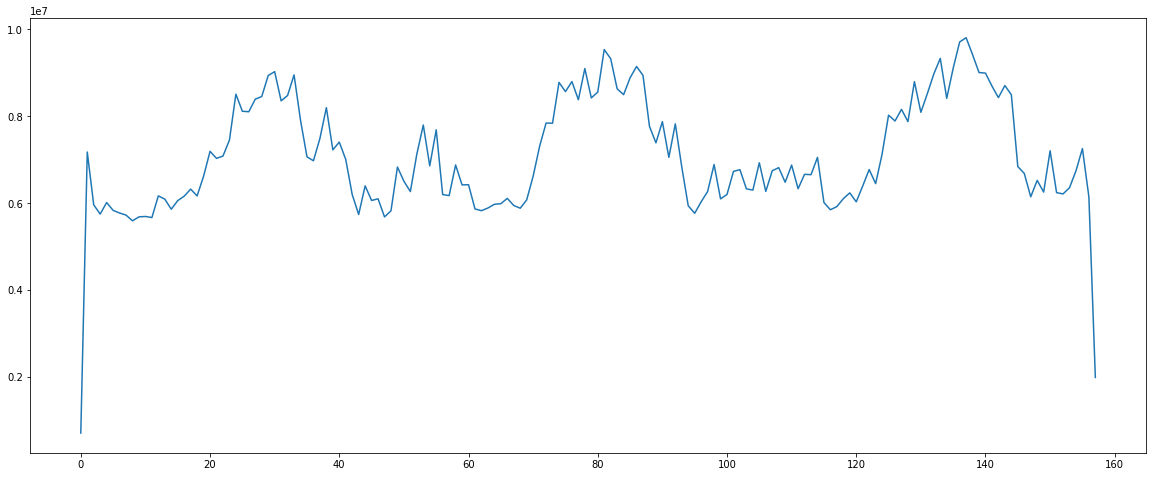

In [ ]:

training_set = df.iloc[:,1:2].values
plt.plot(training_set, label = 'Airline Passangers Data')
plt.show()

In [ ]:

def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

In [ ]:
len(x)

1091

In [ ]:
len(y)

1091

In [ ]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        h_out = h_out.view(-1, self.hidden_size)
        out = self.fc(h_out)
        
        return out

In [ ]:
num_epochs = 2000
learning_rate = 0.01

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1

lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    # obtain the loss function
    loss = criterion(outputs, trainY)
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.33765
Epoch: 100, loss: 0.01286
Epoch: 200, loss: 0.01193
Epoch: 300, loss: 0.00752
Epoch: 400, loss: 0.00355
Epoch: 500, loss: 0.00326
Epoch: 600, loss: 0.00312
Epoch: 700, loss: 0.00307
Epoch: 800, loss: 0.00305
Epoch: 900, loss: 0.00304
Epoch: 1000, loss: 0.00304
Epoch: 1100, loss: 0.00303
Epoch: 1200, loss: 0.00302
Epoch: 1300, loss: 0.00301
Epoch: 1400, loss: 0.00300
Epoch: 1500, loss: 0.00300
Epoch: 1600, loss: 0.00299
Epoch: 1700, loss: 0.00299
Epoch: 1800, loss: 0.00298
Epoch: 1900, loss: 0.00298


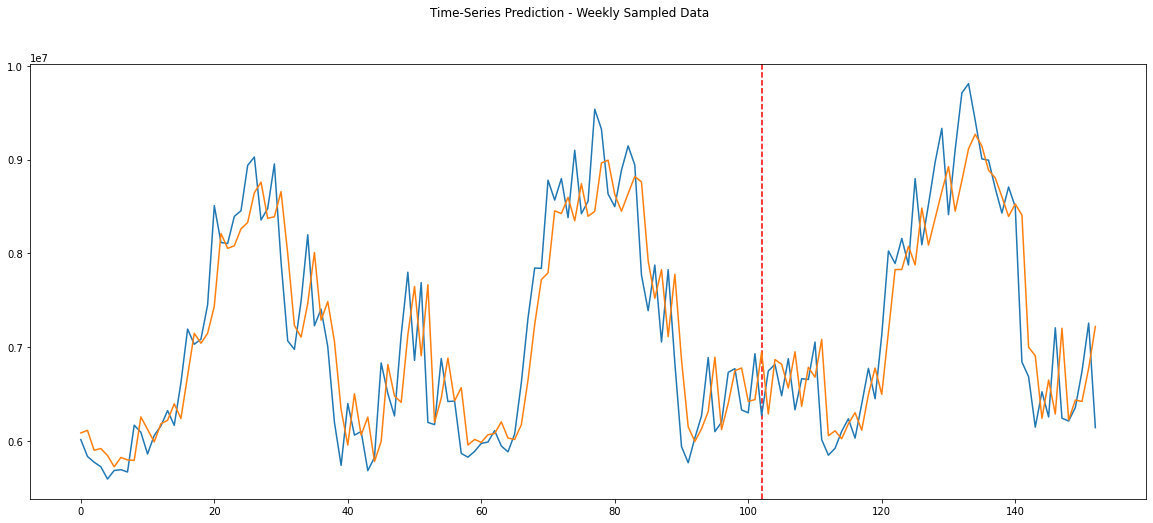

In [ ]:
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)
plt.rcParams["figure.figsize"] = (20,8)
plt.axvline(x=train_size, c='r', linestyle='--')

plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction - Weekly Sampled Data')



plt.show()

In [ ]:
# Calculate MAE and RMSE
def evaluate_prediction(predictions, actual, model_name):
    errors = predictions - actual
    mse = np.square(errors).mean()
    rmse = np.sqrt(mse)
    mae = np.abs(errors).mean()
    mape = np.mean(np.abs(errors/actual))*100

    print(model_name + ':')
    print('Mean Absolute Error: {:.4f}'.format(mae))
    print('Root Mean Square Error: {:.4f}'.format(rmse))
    print('Mean Absolute Percentage Error: {:.4f}'.format(mape))

evaluate_prediction(data_predict, dataY_plot, 'Vanilla LSTM - Weekly')

Vanilla LSTM - Weekly:
Mean Absolute Error: 403322.8750
Root Mean Square Error: 513515.9375
Mean Absolute Percentage Error: 5.6344


In [ ]:
df = pd.concat([df_2017,df_2018,df_2019])
df['HourEnding'] =df['HourEnding'].str.strip()
df[['date','time','n_c']] = df['HourEnding'].str.split(expand=True)
df['datetime'] = (pd.to_datetime(df.pop('date'), format='%m/%d/%Y') + 
                  pd.to_timedelta(df.pop('time') + ':00'))

df = df[['datetime','ERCOT']]
df.set_index('datetime', inplace = True)

df= df.resample('D').apply(sum)
df = df.reset_index()


training_set = df.iloc[:,1:2].values



sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 2000
learning_rate = 0.01

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1

lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    # obtain the loss function
    loss = criterion(outputs, trainY)
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.01414
Epoch: 100, loss: 0.00234
Epoch: 200, loss: 0.00178
Epoch: 300, loss: 0.00162
Epoch: 400, loss: 0.00160
Epoch: 500, loss: 0.00158
Epoch: 600, loss: 0.00156
Epoch: 700, loss: 0.00156
Epoch: 800, loss: 0.00156
Epoch: 900, loss: 0.00155
Epoch: 1000, loss: 0.00155
Epoch: 1100, loss: 0.00155
Epoch: 1200, loss: 0.00155
Epoch: 1300, loss: 0.00155
Epoch: 1400, loss: 0.00155
Epoch: 1500, loss: 0.00155
Epoch: 1600, loss: 0.00155
Epoch: 1700, loss: 0.00155
Epoch: 1800, loss: 0.00154
Epoch: 1900, loss: 0.00154


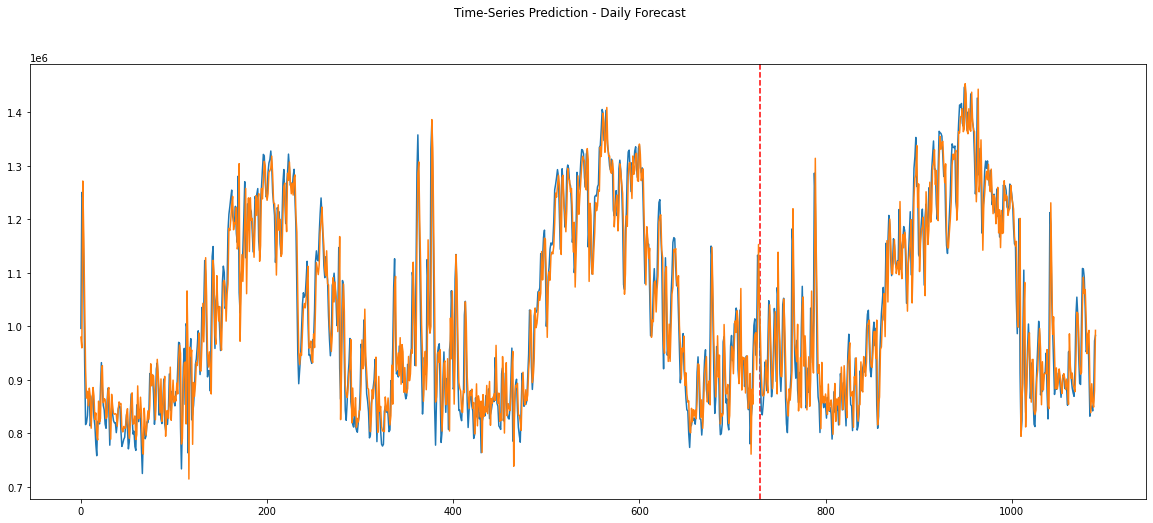

In [ ]:
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)
plt.rcParams["figure.figsize"] = (20,8)
plt.axvline(x=train_size, c='r', linestyle='--')

plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction - Daily Forecast')



plt.show()

In [ ]:
evaluate_prediction(data_predict, dataY_plot, 'Vanilla LSTM - Daily')

Vanilla LSTM - Daily:
Mean Absolute Error: 41468.1328
Root Mean Square Error: 56336.5391
Mean Absolute Percentage Error: 4.1337
